# CRF for image segmentation
Traditionally not used on its own, but as a post processing tool.



1. First need labels from other sources.
    * From Neural Network based model
    * Manual labeling
    * Any other Image Processing method

# Returning to the Feature Functions
1. Feature functions are the key
2. In regards to image segmentation these are the unary and pairwise potential function
    * Unary is pretty set
    * Pairwise has a little more customization

# Goal is to minimize this energy equation
![image](C:/Users/catud/Downloads/EnergyFN1.png)


# Unary Potential
1. When related to image pixels
    * Based on probability or confidence from the classifier that a pixel belongs to a certain label
    * I.e a green pixel has a .95 probability of being labeled grass
2. Basically the 'cost' of assigning a specific label y, to a pixel x, based only on input data.

* More specifically the following equation can be used to calculate the potential from a pixel given a label
    * The higher the probability of the label, the less the cost contribution to the energy function
![Alt text](C:/Users/catud/Downloads/UnaryFN.png "Unary Potential Equation")
* The probability of a label y_i for pixel i, given the input data x_i

# Pairwise Potential
In regards to image segmentation usually comprised of two parts
1. Label Compatibility
2. Feature Similarity

# Label Compatibility
* Penalizes incompatible label types
* If neighbouring pixels share a label, low cost to energy function
* If neighbouring pixels have a different label, high cost to energy function
* Encourages Spatial smoothness
![Alt text](C:/Users/catud/Downloads/LabelFN.png)

# Feature Similarity 
1. Spatial Kernel
    * encourages smooth transitions between labels for pixels that are close together
    * pixels close together have more of an impact
    * Prevent erratic changes of labels over small space
    ![Alt text](C:/Users/catud/Downloads/SpatialFN.png)

2. Color Kernel
    * encourages smooth transitions between labels for pixels with similar colors
    * pixels with similar colors should recieve similar labels
    ![Alt text](C:/Users/catud/Downloads/ColorFN.png)

* Not just limited to these to feature functions

# Putting it together
![Alt text](C:/Users/catud/Downloads/CombinedFN.png)
* compatibility function
* Spacial Kernel
* Color Kernel

![Alt text](C:/Users/catud/Downloads/EnergyFN1.png)
* minimize total energy of Unary + Pairwise potentials
* The goal is to find a label configuration for all pixels that minimizes the overall energy of the system

# Inference Algorithms
1. Belief Propagation
    * Works by exchanging messages between nodes and edges in the graph to update beliefs. Can be computationally expensive with Dense CRFs
2. Mean Field Approximation
    * Simplifies the interaction and assumes independence except through average field created by other nodes
    * Simplifies computation and gives reasonable approximation of global distribution
3. Graph Cuts
    * transforms into min-cut/max-flow problem on a graph.

# Basic Implementation

In [139]:
import numpy as np

def unary_potential(prob, label):

    if label == 1:
        return -np.log(prob)  # Cost of assigning 'cow'
    else:
        return -np.log(1 - prob)  # Cost of assigning 'grass'

* Calculate the unary potential for a pixel based on 'classifier' output.
    * prob is Probability from the classifier that the pixel is a cow.
    * label is The current label of the pixel (0 for grass, 1 for cow).
* returns: Unary potential cost.

![Alt text](C:/Users/catud/Downloads/UnaryFN.png)

In [140]:

def pairwise_potential(label1, label2, color1, color2, beta=0.1, label_cost=1.0):

    color_diff = np.linalg.norm(color1 - color2)
    if label1 == label2: # if labels are the same, higher penalty for same colors for neighboring pixels
        return 0
    else:
        return label_cost * np.exp(-beta * color_diff)


* Calculate the pairwise potential between two neighboring pixels.
    * label1, label2 : Labels of the two pixels.
    * color1, color2: RGB colors of the two pixels.
    * beta: Controls how much the color similarity affects the potential.
* label_cost: Cost of having different labels. i.e label compatibility
* returns: Pairwise potential cost.

![Alt text](C:/Users/catud/Downloads/LabelFN.png) ![Alt text](C:/Users/catud/Downloads/ColorFN.png)

In [141]:
# Two labels, cow and grass
# Assuming classifier output probability that a pixel is a cow 
prob_cow = 0.8 # prob of grass = 1 - p(cow)
label_cow = 1  # Cow
label_grass = 0  # Grass

color_pixel1 = np.array([150, 75, 0])  # White pixel, might be part of a cow
color_pixel2 = np.array([0, 128, 0])      # Green pixel, likely grass

# Unary Potentials
unary_cow = unary_potential(prob_cow, label_cow) # 
unary_grass = unary_potential(prob_cow, label_grass)

# pairwise potentials
pairwise_same = pairwise_potential(label_cow, label_cow, color_pixel1, color_pixel1)
pairwise_diff1 = pairwise_potential(label_cow, label_grass, color_pixel1, color_pixel2)
pairwise_diff2 = pairwise_potential(label_cow, label_grass, color_pixel2, color_pixel2)

In [142]:
print("Certain Unary Potential (Cow):", unary_cow)
print("Uncertain Unary Potential (Grass):", unary_grass)
print("\nPairwise Potential (Same Labels, Same Color):", pairwise_same)
print("Pairwise Potential (Different Label, Different color):", pairwise_diff1)
print("Pairwise Potential (Different Labels, Same Color):", pairwise_diff2)

Certain Unary Potential (Cow): 0.2231435513142097
Uncertain Unary Potential (Grass): 1.6094379124341005

Pairwise Potential (Same Labels, Same Color): 0
Pairwise Potential (Different Label, Different color): 1.232806227066611e-07
Pairwise Potential (Different Labels, Same Color): 1.0


# Image Segmentation example of a Tiger


In [ ]:
!pip install git+https://github.com/lucasb-eyer/pydensecrf.git

In [128]:
import pydensecrf.densecrf as dcrf
from pydensecrf.utils import unary_from_labels, create_pairwise_bilateral, create_pairwise_gaussian
import numpy as np
import cv2
from matplotlib import pyplot as plt

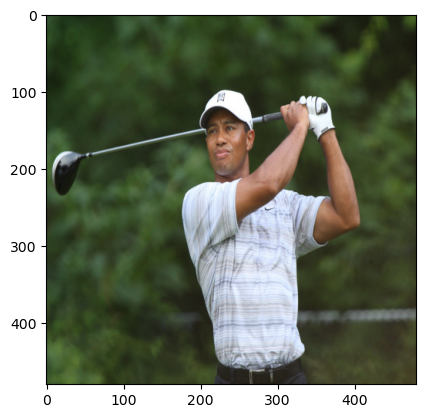

In [136]:
# Load image and the mask
bad_image = cv2.imread('C:/Users/catud/Downloads/tiger.jpg')
bad_mask = cv2.imread('C:/Users/catud/Downloads/tiger_mask1.jpg', 0)  # Assuming mask is grayscale

image = cv2.cvtColor(bad_image, cv2.COLOR_BGR2RGB)

plt.imshow(image)

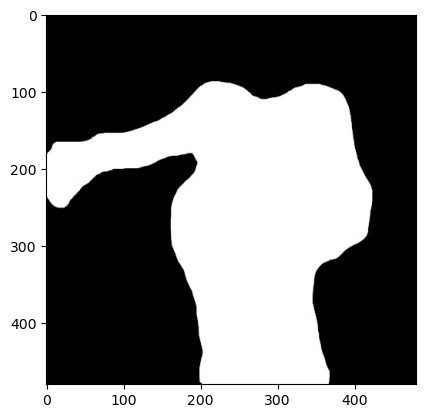

In [132]:
mask = cv2.cvtColor(bad_mask, cv2.COLOR_BGR2RGB)
plt.imshow(mask)

# Using PyDenseCRF
* Dense CRF 
* Every Node is considered a have an edge to every other node
    * Every Pixel connected to every other Pixel
* Pairwise Potentials!
    * Gaussian Pairwise Potentials
        * Smooth labels based on spatial proximity
        * Same as mentioned before
        ![Alt text](C:/Users/catud/Downloads/SpatialFN.png)
    * Bilateral Pairwise Potentials
        * Used to preserve images edges while smoothing homogenous areas
        ![Alt text](C:/Users/catud/Downloads/BilateralFN.png)

In [138]:
mask = (mask > 128).astype(np.uint8)  # Adjust threshold according to mask
# Create unary potential
labels = mask.reshape(-1)  # Flatten the mask
n_labels = 2  # Background and foreground
unary = unary_from_labels(labels, n_labels, gt_prob=0.8, zero_unsure=False) # setup of unary potential

# Setup of the CRF model as we described earlier
crf = dcrf.DenseCRF2D(image.shape[1], image.shape[0], n_labels)  # width, height, n_labels
crf.setUnaryEnergy(unary)
crf.addPairwiseGaussian(sxy=(3, 3), compat=3)
crf.addPairwiseBilateral(sxy=(80, 80), srgb=(13, 13, 13), rgbim=image, compat=10)


AttributeError: module 'pydensecrf.densecrf' has no attribute 'DenseCRF2D'

* 'sxy' is st dev of gaussian and bilateral kernels in the x and y spatial dimensions
    * How quickly the influenmce of a pixels label on its neighbour drop off 
* 'compat' is compatibility coefficient, which scales cost assigned to pairwise potential
    * Higher means more emphasis
* 'srgb' are the st dev of the color channels. 
    * Smaller values would let small differences in color prevent label change

In [137]:
Q = crf.inference(2)  # number of iterations
map_soln = np.argmax(Q, axis=0).reshape((mask.shape))


refined_mask = (map_soln * 255).astype(np.uint8) # Convert back to image to display
cv2.imwrite('refined_tiger_mask.jpg', refined_mask)

# Show
cv2.imshow(refined_mask)
cv2.waitKey(0)
cv2.destroyAllWindows()


NameError: name 'crf' is not defined